In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


In [2]:
def getTrainData(img_size):
    img_dim = (img_size,img_size)

    train_csv = pd.read_csv('train.csv')
    train_arr_imgs = [img_to_array(load_img('train/'+img, target_size=img_dim)) for img in train_csv.image]
    x_train = np.array(train_arr_imgs)

    train_cat = train_csv['category'].values
    y_train = to_categorical(train_cat-1)
    
    np.save("train_dataset_array.npy", x_train)
    np.save("train_dataset_array_labels.npy", y_train)

    return x_train, y_train

def getTestData(img_size):
    img_dim = (img_size,img_size)

    test_csv = pd.read_csv('test.csv')
    #test_arr_imgs = [img_to_array(load_img('test/'+img, target_size=img_dim)) for img in test_csv.image]
    test_arr_imgs = []
    for img in test_csv.image:
        img_array = img_to_array(load_img('test/'+img, target_size=img_dim))
        img_array = img_array/255.0
        test_arr_imgs.append(img_array)
    x_test = np.array(test_arr_imgs)

    test_cat = test_csv.category
    test_cv_y = test_cat-1
    y_test = np.array(test_cv_y)
    
    np.save("test_dataset_array.npy", x_test)
    np.save("test_dataset_array_labels.npy", y_test)
    
    return x_test, y_test

In [3]:
def augData(x_train, y_train, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255,  
                                       rotation_range=30,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=False,
                                       fill_mode='nearest')
    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
    return train_generator

In [49]:
def plotAccuracyLoss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    #Train and validation accuracy
    plt.style.use("classic")
    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training Accurarcy')
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.title('Training Accurarcy and Loss (Simple CNN)')
    plt.legend()
    plt.show()

In [75]:
def printTime(startTime, endTime):
    print("Strat time = "+str(startTime))
    print("End time = "+str(endTime))
    print("Use time = "+str(endTime-startTime))
def convertPred1D(y_pred):
    get_argmax = []
    for i in range(len(y_pred)):
        get_argmax.append(np.argmax(y_pred[i]))
    return get_argmax
def writeCsv(pred, name):
    test_csv = pd.read_csv('test.csv')
    test_dict = {'image': test_csv.image, 'y_true': test_csv.category, 'y_pred': pred}
    df_pred = pd.DataFrame(test_dict)
    export_pred = df_pred.to_csv(r''+name, index = None, header=True)

In [80]:
def printReport(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    df_rp = pd.DataFrame(report).transpose()
    export_report = df_rp.to_csv(r'cls-report_SimpleCNN_R8-e10.csv', index = True, header=True)

In [31]:
def plotConfusionMatrix(array):
    df_cm = pd.DataFrame(array, range(5), range(5))
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, cmap="Blues") 
    plt.show()

In [8]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

model = Sequential()

# Define the first convolutional block
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3),
 data_format='channels_last',
 kernel_regularizer=l2(l=0.001)))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(l=0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Define the second convolutional block
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(l=0.001)))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(l=0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add dropout
model.add(Dropout(rate=0.5))

# Add fully-connected layer
model.add(Dense(256, kernel_regularizer=l2(l=0.001)))
model.add(Activation("relu"))

# Add dropout
model.add(Dropout(rate=0.5))

# Define the SoftMAX classifier
model.add(Dense(5))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 71, 71, 64)        0

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [12]:
batch_size = 32
x_train, y_train = getTrainData(150)
train_generator = augData(x_train, y_train, batch_size)

In [13]:
import time
startTime = time.time()

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(x_train) // batch_size,
                              epochs=10)
endTime = time.time()

  ...
    to  
  ['...']
Train for 78 steps
Epoch 1/10
78/78 [==============================] - 85s 1s/step - loss: 1.9980 - accuracy: 0.3039
Epoch 2/10
78/78 [==============================] - 92s 1s/step - loss: 1.5599 - accuracy: 0.4003
Epoch 3/10
78/78 [==============================] - 96s 1s/step - loss: 1.3806 - accuracy: 0.4846
Epoch 4/10
78/78 [==============================] - 100s 1s/step - loss: 1.2629 - accuracy: 0.5717
Epoch 5/10
78/78 [==============================] - 92s 1s/step - loss: 1.2284 - accuracy: 0.6058
Epoch 6/10
78/78 [==============================] - 96s 1s/step - loss: 1.2104 - accuracy: 0.6414
Epoch 7/10
78/78 [==============================] - 102s 1s/step - loss: 1.1278 - accuracy: 0.6661
Epoch 8/10
78/78 [==============================] - 87s 1s/step - loss: 1.1351 - accuracy: 0.6686
Epoch 9/10
78/78 [==============================] - 86s 1s/step - loss: 1.1015 - accuracy: 0.7034
Epoch 10/10
78/78 [==============================] - 86s 1s/step - loss:

In [141]:
name = 'SimpleCNN_R8-e10'
model_name = 'Simple CNN'

In [142]:
def saveH5(model,name):
    model.save_weights(name+'_model-save-wieghts.h5')
    model.save(name+'_model-save.h5')
saveH5(model,name)

In [143]:
def saveHistory(history, name):
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    hist_csv_file = name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
saveHistory(history,name)

In [144]:
def printTime(startTime, endTime):
    print("Strat time = "+str(startTime))
    print("End time = "+str(endTime))
    print("Use time = "+str(endTime-startTime))
printTime(startTime, endTime)

Strat time = 1583017400.832125
End time = 1583018322.8605058
Use time = 922.0283808708191


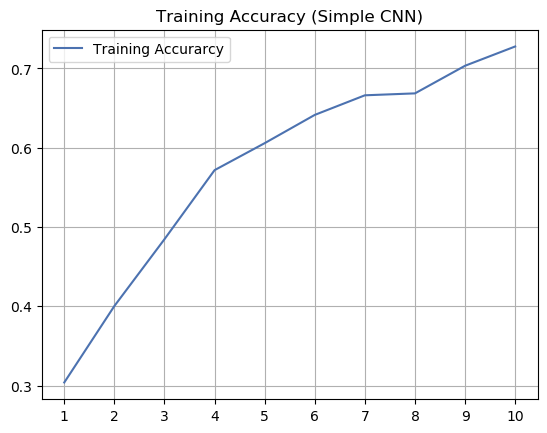

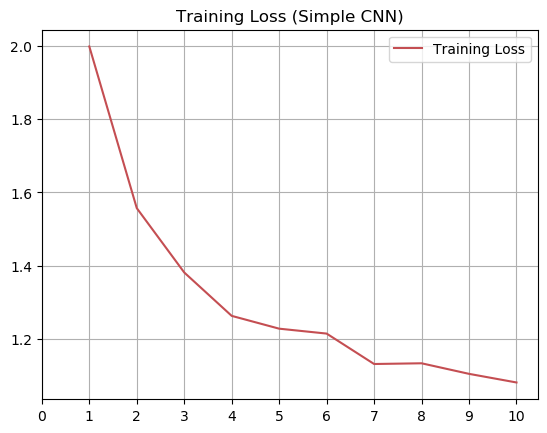

In [145]:
def plotAccuracyLoss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    #Train and validation accuracy
    plt.style.use('default')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    #plt.yticks(np.arange(0, 1))
    plt.plot(epochs, acc, 'b', label='Training Accurarcy')
    plt.title('Training Accuracy ('+model_name+')')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    plt.title('Training Loss ('+model_name+')')
    plt.legend()
    plt.show()
plotAccuracyLoss(history)

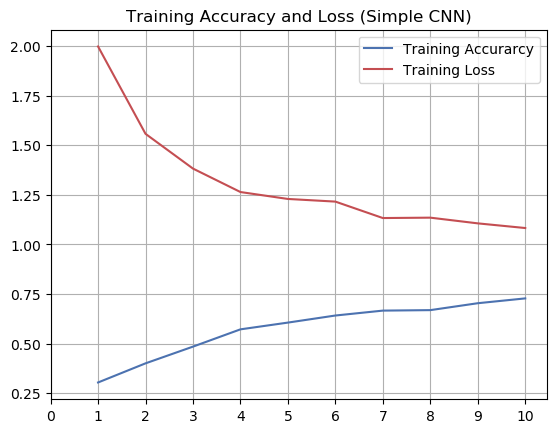

In [146]:
def plotBothAccuracyLoss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    #Train and validation accuracy
    plt.style.use('default')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    #plt.yticks(np.arange(0, 1))
    plt.plot(epochs, acc, 'b', label='Training Accurarcy')
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    plt.title('Training Accuracy and Loss ('+model_name+')')
    plt.legend()
    plt.show()
plotBothAccuracyLoss(history)

In [149]:
x_test, y_test = getTestData(150)

In [150]:
y_pred = model.predict(x_test)

In [151]:
def convertPred1D(y_pred):
    get_argmax = []
    for i in range(len(y_pred)):
        get_argmax.append(np.argmax(y_pred[i]))
    return get_argmax
y_pred1d = convertPred1D(y_pred)

In [152]:
def savePrediction(pred, name):
    test_csv = pd.read_csv('test.csv')
    test_dict = {'image': test_csv.image, 'y_true': test_csv.category-1, 'y_pred': pred}
    df_pred = pd.DataFrame(test_dict)
    export_pred = df_pred.to_csv(r''+name+'_y-prediction.csv', index = None, header=True)
savePrediction(y_pred1d, name)

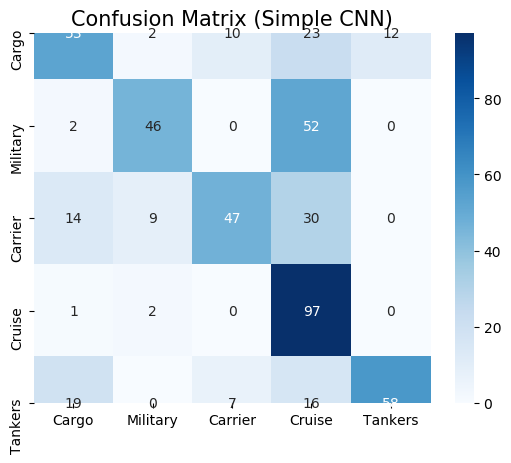

In [156]:
def plotConfusionMatrix(array, name):
    df_cm = pd.DataFrame(array, index = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers'], columns = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers'])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap="Blues")
    plt.title('Confusion Matrix ('+name+')',fontsize = 15)
    plt.show()
plotConfusionMatrix(confusion_matrix(y_test, y_pred1d),model_name)

In [154]:
confusion_matrix(y_test, y_pred1d)

array([[53,  2, 10, 23, 12],
       [ 2, 46,  0, 52,  0],
       [14,  9, 47, 30,  0],
       [ 1,  2,  0, 97,  0],
       [19,  0,  7, 16, 58]], dtype=int64)

In [155]:
def printReport(y_test, y_pred, name):
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    df_rp = pd.DataFrame(report).transpose()
    export_rp = df_rp.to_csv(r''+name+'_cls-report.csv', index = None, header=True)
printReport(y_test, y_pred1d, name)

              precision    recall  f1-score   support

           0       0.60      0.53      0.56       100
           1       0.78      0.46      0.58       100
           2       0.73      0.47      0.57       100
           3       0.44      0.97      0.61       100
           4       0.83      0.58      0.68       100

    accuracy                           0.60       500
   macro avg       0.68      0.60      0.60       500
weighted avg       0.68      0.60      0.60       500

